# Predicting Bike Demand 

Author-Suneet Sawant


This notebook is an attempt to predict the number of bikes demanded based on [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/data) dataset. 

The notebook is divided in following way :
1. Overview of the available training data, identifying the dependent and independent variables,missing values,etc 
2. Exploratory Analsis of the data and visualising the relationship between the variables. 
3. Outlier detection, imputing missing values if required.
4. Building the model and computing log mean square error. 
5. Predicting the values on the test data and final submission.


Lets import all the required libraries and load our training data.
  

 

In [430]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cPickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams["axes.labelsize"] = 30
sns.set(font_scale=1.5)

In [431]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


## Overview of the training data 

We have the follwing information about training data from [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/data)
- datetime   - hourly date + timestamp  
- season     -  1: spring, 2: summer, 3: fall, 4: winter 
- holiday    - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather    - 
               1: Clear, Few clouds, Partly cloudy, Partly cloudy 
               2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
               3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
               4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp       - temperature in Celsius
- atemp      - "feels like" temperature in Celsius
- humidity   - relative humidity
- windspeed  - wind speed
- casual     - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count      - number of total rentals


Further we can conclude below after loading the data :

1. __12__ variables and __10886__ entries. 
2. No missing values so we don't have to impute any missing values as all entries are non-null.
3. _count_ (number of bikes used by all users) is our main target variable while _registered_ (number of bikes used by registered users) and _casual_ (number of bikes used by casual users) potentially can be target variables too.
4. Rest __9__ variables are our potential independent variables.


We can look at the first few entries to get the feel for the data

In [432]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Given the first look, the variable _datetime_ cannot be used directly. So lets split it into corresponding _hour_, _day_, _month_, _year_  variables. 

Note that _day_ will correspond to the day (sun,mon,etc) and not the actual values. _day_ takes on values from 0 (Monday) to 6 (Sunday). The rest other variables are self explanatory. 

In [433]:
## Extract hour, day, month, year from datetime

df['hour'] = df['datetime'].apply(lambda x : int(x.split(' ')[1].split(':')[0]))
df['day'] = df['datetime'].apply(lambda x : parser.parse(x).weekday())

df['month'] = df['datetime'].apply(lambda x : int(x.split(' ')[0].split('-')[1]))
df['year'] = df['datetime'].apply(lambda x : int(x.split(' ')[0].split('-')[0]))






## Exploratory Data Analysis 

In this section we will analyse our independent variables and their relationship with our target _count_.

Before diving into analysis lets identify the variables type :

Categorical variables = _season, weather, holiday, workingday, year, hour, day, month_ 

Continuos variables = _temp, atemp, windspeed, humidity_

Lets convert the datatypes of categorical variables.

In [434]:
 ## Convert to datatype categorical 
df['season']=df['season'].astype('category')
df['weather']=df['weather'].astype('category')
df['holiday']=df['holiday'].astype('category')
df['workingday']=df['workingday'].astype('category')
df['year'] = df['year'].astype('category')
df['hour'] = df['hour'].astype('category')
df['day'] = df['day'].astype('category')
df['month'] = df['month'].astype('category')

Now that we have the required datatypes, we can move forward with the analysis. For visualisation purpose, we will map the values of categorical variables corresponding to the entities they actually corresponds. For eg. _season_ = 1 corresponds to spring and likewise.  

Note that _weather_ = 1 is mapped to '_Clear_' and not to 'Clear,Partly cloudy,etc' and so on for ease of visualization.

In [435]:
# Defining dictionaries mapping the categorical variables values.
Season = {1:'Spring',2:'Summer',3:'Fall',4:'Winter'}
Weather = {1:'Clear',2:'Mist',3:'Low Rain',4:'High Rain'}
holiday = {1:'Yes',0:'No'}
workingday = {1:'Yes',0:'No'}
day = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:"Sun"}
month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:"July",8:'Aug',9:'Sep',10:'Oct',11:"Nov",12:"Dec"}
    

In [436]:
# Transform the categorical variables
categ_var = {'season':Season,'weather':Weather,'holiday':holiday,'workingday':workingday,'day':day,'month':month}
for key,val in categ_var.iteritems():
    df[key] = df[key].map(val)

# Inverse dictionay mapping ( Useful for converting back to numerical values for building model)    
def inverse_map(dic):
    res = {v:k for k,v in dic.iteritems()}
    return res    

Lets see the distribution of target variable _count_.

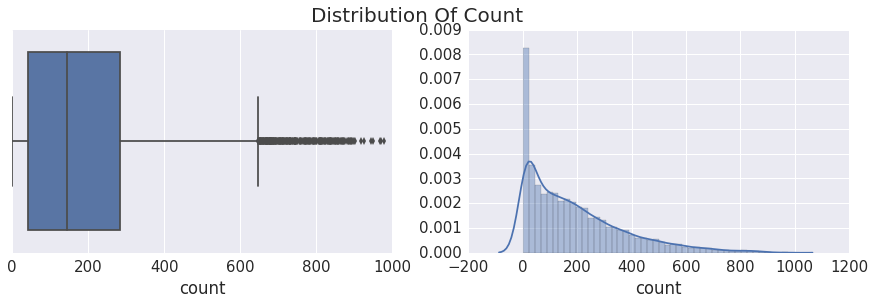

In [437]:
## Plot distribution of variable count

fig,axs = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(x='count',data=df,ax=axs[0])
sns.distplot(df['count'],ax=axs[1])
plt.suptitle('Distribution Of Count',fontsize = 20)



The distribution of our target variable _count_ is right skewed. Further many observations are out of the quartile range. Presence of out of quartile values usually indicates outliers. But in this case, as there are so many observations out of quartile range, it seems those are natural outliers. So we won't impute or remove these outliers. 

Lets look at the relationships between count and categorical variables.

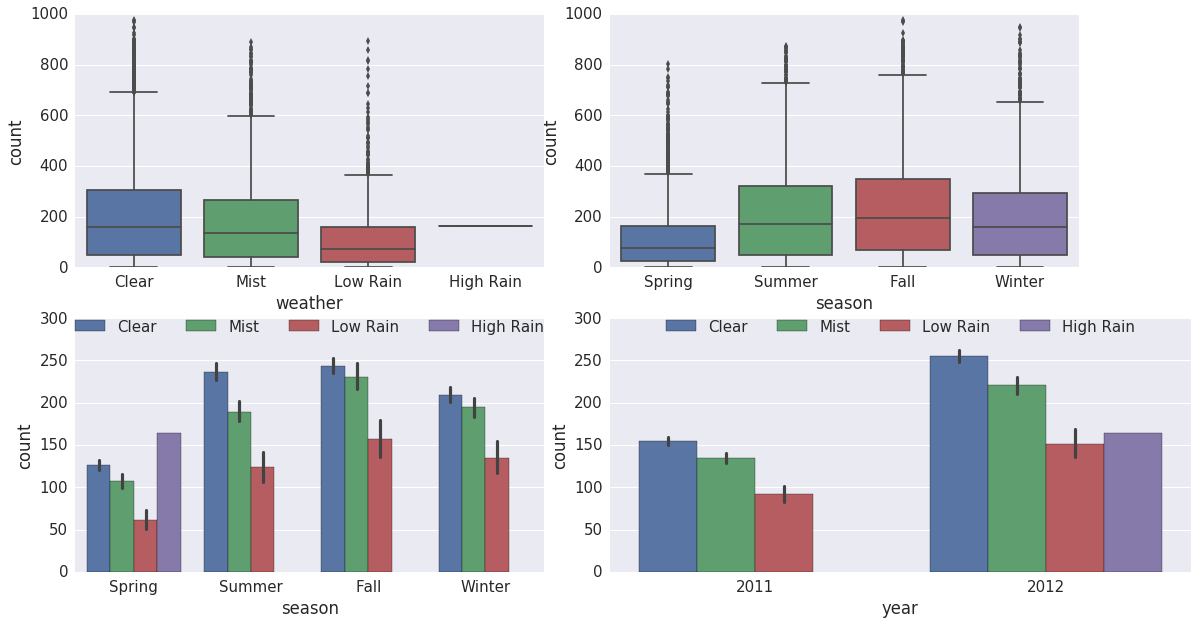

In [438]:
## Visualisation of season and weather relationship with count 
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[10,10,1]) 
ax0 = plt.subplot(gs[0,1])
sns.boxplot(x='season',y='count',data=df,ax=ax0)


ax1 = plt.subplot(gs[0,0])
sns.boxplot(x='weather',y='count',data=df,ax=ax1)



ax2 = plt.subplot(gs[1,:1])
sns.barplot(x='season',y='count',hue = 'weather',data=df,ax=ax2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)

ax3 = plt.subplot(gs[1,1:])
sns.barplot(x='year',y='count',hue = 'weather',data=df,ax=ax3)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)


From the above plots, the demand for bikes is higher when the weather is clear, obviously because people would prefer to ride in clear weather instead of rain. There is unsual high count data when the weather was highly rainy.
Probably, it is an error in documentation. Across seasons, spring is less preferred compared to other seasons. Also, people prefer clear weather over rainy across all seasons as well. With each year, the demand for bike rentals is on increase. This implies year is a good indicator of the bike demand. Weather is also a good indicator. But season looks fairly even for bike rentals.   

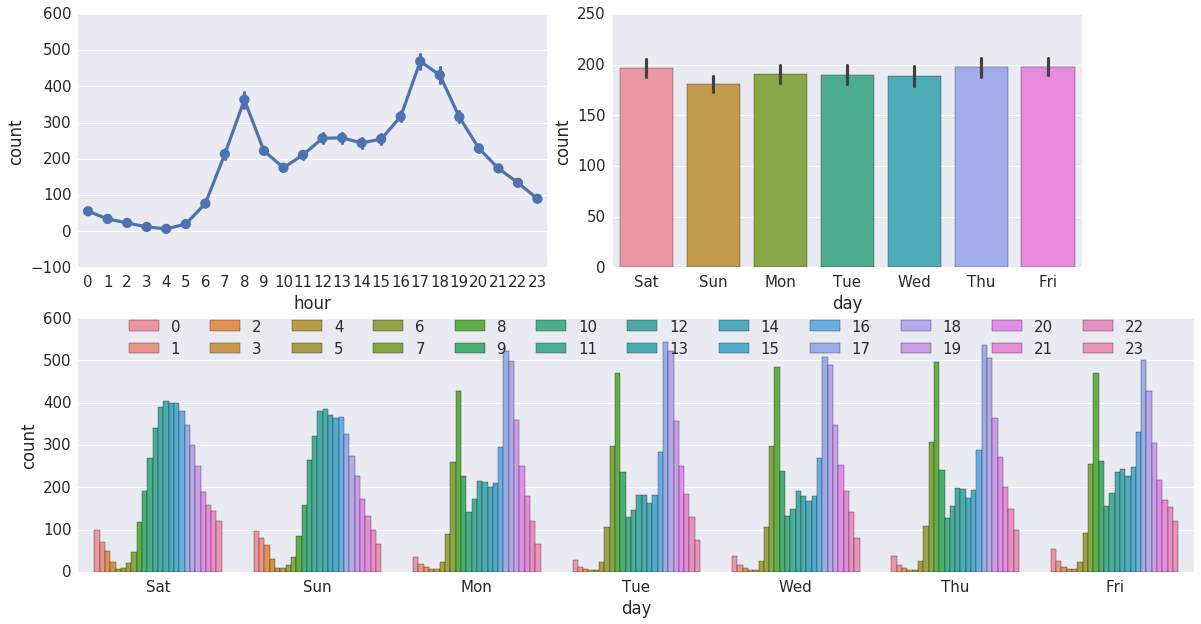

In [439]:
## Visualisation of hour,day relationship with count
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[10,10,1]) 
ax0 = plt.subplot(gs[0,0])
sns.pointplot(x='hour',y='count',data=df,ax=ax0)

ax1 = plt.subplot(gs[0,1])
sns.barplot(x='day',y='count',data=df,ax=ax1)



ax2 = plt.subplot(gs[1,:])
sns.barplot(x='day',y='count',hue = 'hour',data=df,ax=ax2,ci=None)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=12, fancybox=True, shadow=True)



The demand for bikes is highest in the morning around 7 to 9 and in the evening around 5 and 6(18:00). The most likely reason is that people go to work during these time frame and therefore higher demand for bikes. During weekends the distribution is normal with no peaks. Also,the total demand across day is approximately uniform but it is useful to predict hourly demand when we also take hour in account. 

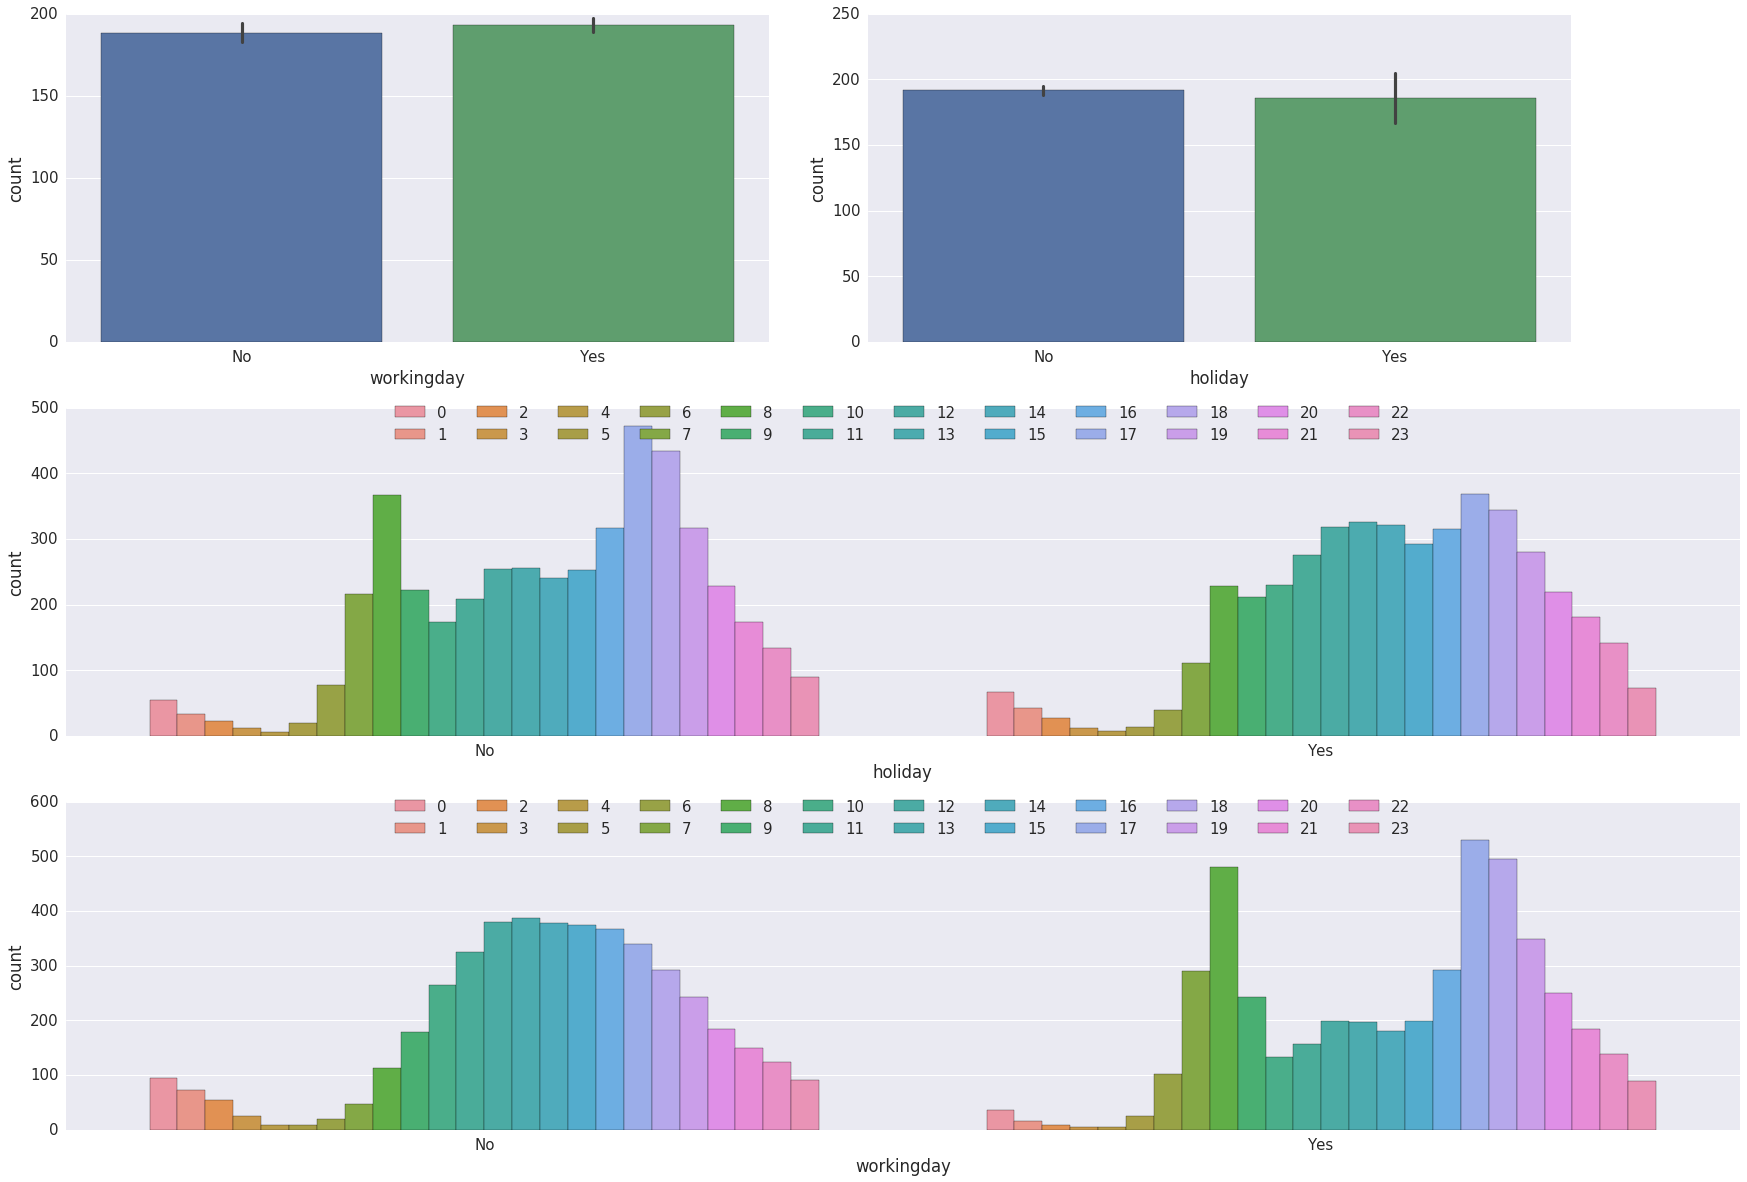

In [440]:
## Visualisation of holiday and workingday relationship with count 
fig = plt.figure(figsize=(30, 20)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[10,10,1]) 
ax0 = plt.subplot(gs[0,1])
sns.barplot(x='holiday',y='count',data=df,ax=ax0)

ax1 = plt.subplot(gs[0,0])
sns.barplot(x='workingday',y='count',data=df,ax=ax1)


ax2 = plt.subplot(gs[1,:])
sns.barplot(x='holiday',y='count',hue = 'hour',data=df,ax=ax2,ci=None)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=12, fancybox=True, shadow=True)

ax3 = plt.subplot(gs[2,:])
sns.barplot(x='workingday',y='count',hue = 'hour',data=df,ax=ax3,ci=None)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=12, fancybox=True, shadow=True)



So we have another variables workingday and holiday for which count is evenly distributed. But together with variable time, then working day and holiday have their effect on count. 

Lets analyse the remaining continuous variables.

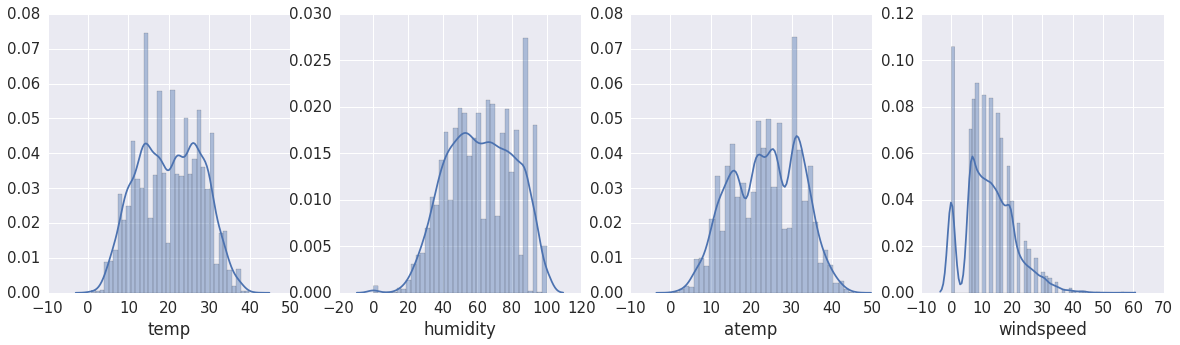

In [442]:
## Visualisation of continuos variables 

fig, axs = plt.subplots(1,4,figsize=(20,5))
sns.distplot(df['temp'],ax=axs[0])
sns.distplot(df['humidity'],ax=axs[1])
sns.distplot(df['atemp'],ax=axs[2])
sns.distplot(df['windspeed'],ax=axs[3])




The distribution of temp,atemp,humidity is normal. Distribution of windspeed is right skewed with many zero values.
Lets look at the correlation of these variables with count.

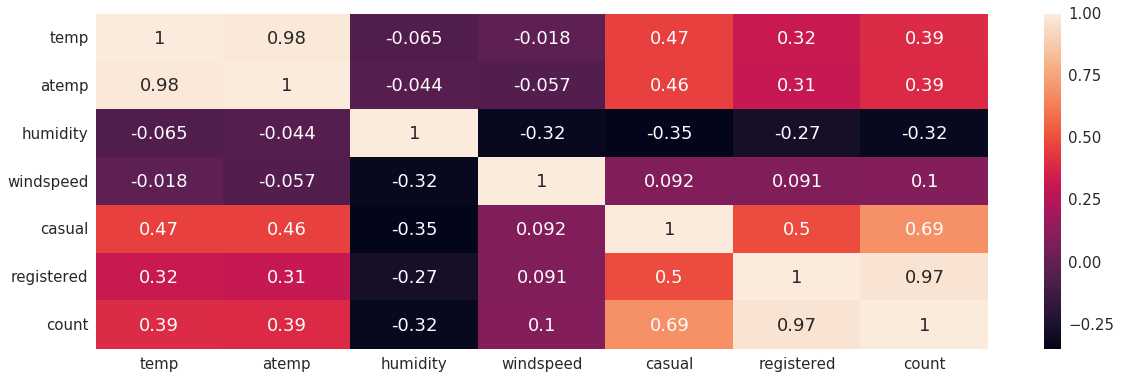

In [443]:
## Plotting the corroleation of continuous variables with count
corr = df.corr()
fig, axs = plt.subplots(figsize=(20,6))
ax = sns.heatmap(corr,annot=True)


Atemp and temp as expected is highly correlated. There is moderate correlation of count with temp,atemp and humidity. we expect these variables to be significant indicator of count. As temp and atemp are highly correlated we will use only temp variable.

## Building Model

We will build 2 models linear regression and random forest regression.
Our independent variables are _season_, _holiday_, _workingday_, _weather_, _temp_, _humidity_, _windspeed_, _hour_,_year_, _day_, _month_.

As we want to select model based on log mean square error we define a function logMLSE() to calculate that.

Lets Build the models.

In [444]:
## Function to calculate log mean square error
def logMLSE(y_tar,y_pred):
    n = np.size(y_tar)
    a = np.log(y_pred+1)
    b = np.log(y_tar+1)
    #print(np.sqrt(np.sum(np.square(a-b))/n))
    return np.sqrt(np.sum(np.square(a-b)/n))

In [445]:
## Remap the categorical values to numerical values
for key,val in categ_var.iteritems():
    df[key] = df[key].map(inverse_map(val))

In [446]:
## Linear Regression Model
from sklearn import linear_model
lr = linear_model.LinearRegression()
Y = np.log(df['count'])

var = ['season','holiday','workingday','weather','temp','humidity','windspeed','hour','year','day','month']
a =[col for col in df.columns if col in var]
X = df[a]
X
lr.fit(X,Y)
y_pred=lr.predict(X)
logMLSE(np.exp(Y),np.exp(y_pred))




1.0193077082236832

In [449]:
## Random Forest Model
from sklearn.ensemble import RandomForestRegressor
Rf = RandomForestRegressor(n_estimators=100)
Rf.fit(X,Y)
y_pred=Rf.predict(X)
print(logMLSE(np.exp(Y),np.exp(y_pred)))



0.108671679272


In [450]:
with open('Rf', 'wb') as f:
    cPickle.dump(Rf, f)


## Final Submission 

Since Random Forest is doing better than Linear Regression, we will use Random forest model on our test set.

In [451]:

dfTest = pd.read_csv('test.csv')
dfTest['hour'] = dfTest['datetime'].apply(lambda x : int(x.split(' ')[1].split(':')[0]))
dfTest['day'] = dfTest['datetime'].apply(lambda x : parser.parse(x).weekday())
#df['count']=df['count'].apply(lambda x : np.log(x))
dfTest['month'] = dfTest['datetime'].apply(lambda x : int(x.split(' ')[0].split('-')[1]))
dfTest['year'] = dfTest['datetime'].apply(lambda x : int(x.split(' ')[0].split('-')[0]))
#del df['datetime']


dfTest['season']=dfTest['season'].astype('category')
dfTest['weather']=dfTest['weather'].astype('category')
dfTest['holiday']=dfTest['holiday'].astype('category')
dfTest['workingday']=dfTest['workingday'].astype('category')
dfTest['year'] = dfTest['year'].astype('category')
dfTest['hour'] = dfTest['hour'].astype('category')
dfTest['day'] = dfTest['day'].astype('category')
dfTest['month'] = dfTest['month'].astype('category')



In [452]:
a =[col for col in df.columns if col in var]
X_test = dfTest[a]

with open('Rf', 'rb') as f:
    Rf = cPickle.load(f)
y_pred = Rf.predict(X_test)

res = pd.DataFrame({"datetime": dfTest['datetime'],"count":np.exp(y_pred)})
res.to_csv('bike_predictions.csv', index=False)